In [6]:
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import scipy

In [7]:
# Load TF-IDF features from pickle
# with open('features/tfidf_features.pkl', 'rb') as f:
#     tfidf_features = pickle.load(f)
#     X_tfidf = tfidf_features['matrix']

# with open('features/bigram_features.pkl', 'rb') as f:
#     bigram_features = pickle.load(f)
#     X_bigram = bigram_features['matrix']

with open('features/data.pkl', 'rb') as f:
    movies_clean = pickle.load(f)

with open('features/genres.pkl', 'rb') as f:
    genres = pickle.load(f)

# X_combined = hstack([X_tfidf, X_bigram])

In [8]:
# Check the aviability of GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [9]:
class MovieGenreDataset(Dataset):
    def __init__(self, X, genres, mlb=None, is_train=False):
        # Convert sparse matrix to dense tensor
        if isinstance(X, (scipy.sparse.csr_matrix, scipy.sparse.csc_matrix)):
            self.features = torch.FloatTensor(X.toarray())
        else:
            self.features = torch.FloatTensor(X)
        
        # Convert genres to multi-hot encoding
        if is_train:
            self.mlb = MultiLabelBinarizer()
            self.labels = torch.FloatTensor(self.mlb.fit_transform(genres))
        elif mlb is not None:
            self.mlb = mlb
            self.labels = torch.FloatTensor(self.mlb.transform(genres))
        else:
            raise ValueError("Must provide MLBinarizer for val/test sets")
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
    def get_num_classes(self):
        return len(self.mlb.classes_)
    
    def get_mlb(self):
        return self.mlb


In [48]:
# First split: separate test set (80% train+val, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(
    movies_clean["cleaned_overview"], genres, test_size=0.2, random_state=42,
)

# Second split: separate train and validation from temp (0.8 * 0.8 = 64% train, 0.8 * 0.2 = 16% val)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42,
)

tfidf_vec = TfidfVectorizer(max_features=1000, ngram_range=(1, 2), min_df=2, max_df=0.95, sublinear_tf=True)
# bigram = CountVectorizer(ngram_range=(2, 2), max_features=1000, min_df=2, max_df=0.95)
trigram = CountVectorizer(ngram_range=(3, 3), max_features=2000)
X_train_tfidf = tfidf_vec.fit_transform(X_train)
X_val_tfidf = tfidf_vec.transform(X_val)
X_test_tfidf = tfidf_vec.transform(X_test)
# X_train_bigram = bigram.fit_transform(X_train)
# X_val_bigram = bigram.transform(X_val)
# X_test_bigram = bigram.transform(X_test)
X_train_trigram = trigram.fit_transform(X_train)
X_val_trigram = trigram.transform(X_val)
X_test_trigram = trigram.transform(X_test)

# Combine TF-IDF and bigram features
X_train = hstack([X_train_tfidf, X_train_trigram])
X_val = hstack([X_val_tfidf, X_val_trigram])
X_test = hstack([X_test_tfidf, X_test_trigram])

# PCA reduction
pca = PCA(n_components=100)
# X_train_pca = pca.fit_transform(X_train_trigram.toarray())
# X_val_pca = pca.transform(X_val_trigram.toarray())
# X_test_pca = pca.transform(X_test_trigram.toarray())

# Create datasets for each split
train_dataset = MovieGenreDataset(X_train, y_train, is_train=True)
mlb = train_dataset.get_mlb()
val_dataset = MovieGenreDataset(X_val, y_val, mlb=mlb)
test_dataset = MovieGenreDataset(X_test, y_test, mlb=mlb)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

Training samples: 6380
Validation samples: 1596
Testing samples: 1995


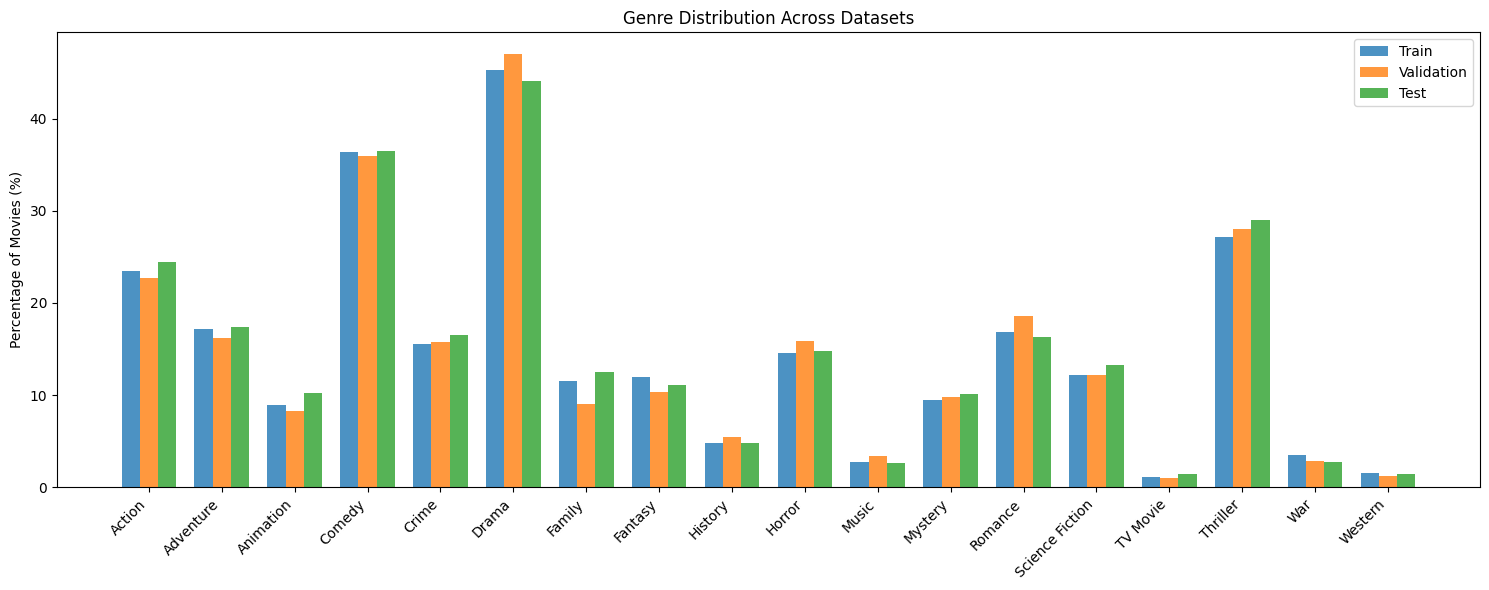


Genre distribution (%):
Genre              Train   Validation     Test
---------------------------------------------
Action             23.46        22.74    24.46
Adventure          17.15        16.23    17.39
Animation           8.95         8.27    10.28
Comedy             36.36        35.96    36.44
Crime              15.53        15.73    16.54
Drama              45.28        46.99    44.11
Family             11.57         9.02    12.53
Fantasy            11.96        10.40    11.13
History             4.80         5.45     4.86
Horror             14.53        15.85    14.79
Music               2.71         3.38     2.61
Mystery             9.53         9.77    10.13
Romance            16.83        18.55    16.34
Science Fiction    12.16        12.16    13.28
TV Movie            1.16         1.00     1.45
Thriller           27.12        28.07    29.02
War                 3.48         2.88     2.81
Western             1.60         1.25     1.50


In [49]:
import numpy as np

import matplotlib.pyplot as plt

# Get labels for each dataset
train_labels = train_dataset.labels.numpy()
val_labels = val_dataset.labels.numpy()
test_labels = test_dataset.labels.numpy()

# Calculate the percentage of each genre in each dataset
train_dist = train_labels.sum(axis=0) / len(train_labels) * 100
val_dist = val_labels.sum(axis=0) / len(val_labels) * 100
test_dist = test_labels.sum(axis=0) / len(test_labels) * 100

# Get genre names
genre_names = train_dataset.mlb.classes_

# Create a bar plot
fig, ax = plt.subplots(figsize=(15, 6))

x = np.arange(len(genre_names))
width = 0.25

ax.bar(x - width, train_dist, width, label='Train', alpha=0.8)
ax.bar(x, val_dist, width, label='Validation', alpha=0.8)
ax.bar(x + width, test_dist, width, label='Test', alpha=0.8)

ax.set_ylabel('Percentage of Movies (%)')
ax.set_title('Genre Distribution Across Datasets')
ax.set_xticks(x)
ax.set_xticklabels(genre_names, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

# Print exact percentages
print("\nGenre distribution (%):")
print(f"{'Genre':<15} {'Train':>8} {'Validation':>12} {'Test':>8}")
print("-" * 45)
for i, genre in enumerate(genre_names):
    print(f"{genre:<15} {train_dist[i]:8.2f} {val_dist[i]:12.2f} {test_dist[i]:8.2f}")

In [54]:
# Now set the hyperparameters with correct output_size
input_size = X_train.shape[1]
output_size = train_dataset.get_num_classes()
num_epochs = 100
learning_rate = 1e-4
weight_decay = 5e-4
dropout_rate = 0.6
hidden_size = 256
batch_size = 64
pos_counts = np.sum(train_dataset.labels.numpy(), axis=0)
neg_counts = len(train_dataset) - pos_counts
pos_weights = torch.FloatTensor(neg_counts / pos_counts).to(device)

print(f"Number of features (input_size): {input_size}")
print(f"Number of genres (output_size): {output_size}")

Number of features (input_size): 3000
Number of genres (output_size): 18


In [55]:
# Create dataloaders for each split
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [56]:
class FeedForwardClassifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(FeedForwardClassifier, self).__init__()
        
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.BatchNorm1d(hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate),

            torch.nn.Linear(hidden_size, hidden_size // 2),
            torch.nn.BatchNorm1d(hidden_size // 2),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate),
            
            torch.nn.Linear(hidden_size // 2, output_size)
        )
        
    def forward(self, x):
        return self.layers(x)

total_samples = len(y_train)

# Initialize model, loss function, and optimizer
model = FeedForwardClassifier(input_size, hidden_size, output_size, dropout_rate).to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weights, reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max', 
    factor=0.7, 
    patience=4,
    min_lr=1e-6,
)

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define early stopping parameters
patience = 7  # Number of epochs to wait before early stopping
best_val_f1 = 0  # Initialize best validation F1 score
patience_counter = 0  # Initialize patience counter

# Lists to store metrics
history = {
    'train_loss': [], 'val_loss': [],
    'train_accuracy': [], 'val_accuracy': [],
    'train_precision': [], 'val_precision': [],
    'train_recall': [], 'val_recall': [],
    'train_f1': [], 'val_f1': []
}

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    all_train_predictions = []
    all_train_targets = []
    
    for batch_features, batch_labels in train_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        
        optimizer.zero_grad()
        logits = model(batch_features)
        loss = criterion(logits, batch_labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_train_loss += loss.item()
        
        # Store predictions and targets for metrics
        predictions = (torch.sigmoid(logits) > 0.5)
        all_train_predictions.append(predictions.cpu().detach())
        all_train_targets.append(batch_labels.cpu().detach())
    
    # Concatenate all batches
    train_predictions = torch.cat(all_train_predictions, dim=0).numpy()
    train_targets = torch.cat(all_train_targets, dim=0).numpy()
    
    # Calculate training metrics
    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = accuracy_score(train_targets, train_predictions)
    train_precision = precision_score(train_targets, train_predictions, average='samples', zero_division=0)
    train_recall = recall_score(train_targets, train_predictions, average='samples', zero_division=0)
    train_f1 = f1_score(train_targets, train_predictions, average='samples', zero_division=0)
    
    # Validation phase
    model.eval()
    total_val_loss = 0
    all_val_predictions = []
    all_val_targets = []
    
    with torch.no_grad():
        for batch_features, batch_labels in val_loader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)
            
            logits = model(batch_features)
            loss = criterion(logits, batch_labels)
            total_val_loss += loss.item()
            
            # Store predictions and targets for metrics
            predictions = (torch.sigmoid(logits) > 0.5)
            all_val_predictions.append(predictions.cpu().detach())
            all_val_targets.append(batch_labels.cpu().detach())
    
    
    # Concatenate all batches
    val_predictions = torch.cat(all_val_predictions, dim=0).numpy()
    val_targets = torch.cat(all_val_targets, dim=0).numpy()
    
    # Calculate validation metrics
    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_targets, val_predictions)
    val_precision = precision_score(val_targets, val_predictions, average='samples', zero_division=0)
    val_recall = recall_score(val_targets, val_predictions, average='samples', zero_division=0)
    val_f1 = f1_score(val_targets, val_predictions, average='samples', zero_division=0)

    scheduler.step(val_f1)
    
    # Store metrics in history
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['train_accuracy'].append(train_accuracy)
    history['val_accuracy'].append(val_accuracy)
    history['train_precision'].append(train_precision)
    history['val_precision'].append(val_precision)
    history['train_recall'].append(train_recall)
    history['val_recall'].append(val_recall)
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_f1)
    
    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train - Loss: {avg_train_loss:.4f}, Acc: {train_accuracy:.4f}, F1: {train_f1:.4f}')
    print(f'Val   - Loss: {avg_val_loss:.4f}, Acc: {val_accuracy:.4f}, F1: {val_f1:.4f}')
    
    # Early stopping (using F1 score instead of just loss)
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0
        # Save the best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history,
            'best_f1': best_val_f1
        }, 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

Epoch [1/100]
Train - Loss: 1.2540, Acc: 0.0000, F1: 0.2092
Val   - Loss: 1.1640, Acc: 0.0000, F1: 0.2134
Epoch [2/100]
Train - Loss: 1.2149, Acc: 0.0000, F1: 0.2241
Val   - Loss: 1.1473, Acc: 0.0000, F1: 0.2455
Epoch [3/100]
Train - Loss: 1.1726, Acc: 0.0000, F1: 0.2418
Val   - Loss: 1.1307, Acc: 0.0000, F1: 0.2722
Epoch [4/100]
Train - Loss: 1.1512, Acc: 0.0000, F1: 0.2531
Val   - Loss: 1.1146, Acc: 0.0000, F1: 0.3065
Epoch [5/100]
Train - Loss: 1.1164, Acc: 0.0000, F1: 0.2749
Val   - Loss: 1.0966, Acc: 0.0013, F1: 0.3387
Epoch [6/100]
Train - Loss: 1.0833, Acc: 0.0002, F1: 0.2939
Val   - Loss: 1.0793, Acc: 0.0006, F1: 0.3604
Epoch [7/100]
Train - Loss: 1.0446, Acc: 0.0005, F1: 0.3164
Val   - Loss: 1.0622, Acc: 0.0025, F1: 0.3884
Epoch [8/100]
Train - Loss: 1.0136, Acc: 0.0006, F1: 0.3367
Val   - Loss: 1.0385, Acc: 0.0038, F1: 0.4013
Epoch [9/100]
Train - Loss: 0.9832, Acc: 0.0009, F1: 0.3568
Val   - Loss: 1.0178, Acc: 0.0063, F1: 0.4207
Epoch [10/100]
Train - Loss: 0.9508, Acc: 0.00

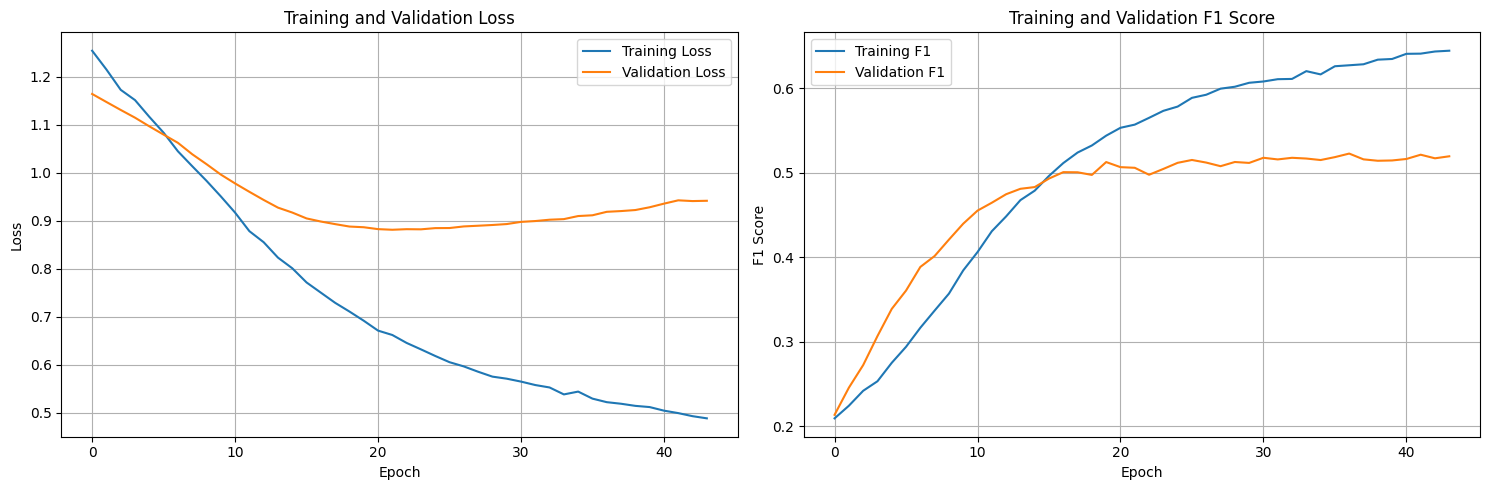

Best Training F1: 0.6442
Best Validation F1: 0.5225


In [58]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
ax1.plot(history['train_loss'], label='Training Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Plot F1 Score
ax2.plot(history['train_f1'], label='Training F1')
ax2.plot(history['val_f1'], label='Validation F1')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1 Score')
ax2.set_title('Training and Validation F1 Score')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print best scores
best_train_f1 = max(history['train_f1'])
best_val_f1 = max(history['val_f1'])
print(f"Best Training F1: {best_train_f1:.4f}")
print(f"Best Validation F1: {best_val_f1:.4f}")

In [59]:
# from sklearn.multioutput import MultiOutputClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import f1_score, precision_score, recall_score
# import numpy as np
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import uniform, randint
# # Create and train the model
# lr_model = MultiOutputClassifier(LogisticRegression(max_iter=1000, C=1.0, solver='liblinear'))
# lr_model.fit(X_train.toarray(), train_dataset.labels.numpy())

# # Make predictions on train and validation sets
# train_pred = lr_model.predict(X_train.toarray())
# val_pred = lr_model.predict(X_val.toarray())

# # Calculate metrics for training set
# train_precision = precision_score(train_dataset.labels.numpy(), train_pred, average='samples')
# train_recall = recall_score(train_dataset.labels.numpy(), train_pred, average='samples')
# train_f1 = f1_score(train_dataset.labels.numpy(), train_pred, average='samples')

# # Calculate metrics for validation set
# val_precision = precision_score(val_dataset.labels.numpy(), val_pred, average='samples')
# val_recall = recall_score(val_dataset.labels.numpy(), val_pred, average='samples')
# val_f1 = f1_score(val_dataset.labels.numpy(), val_pred, average='samples')

# print("Training Metrics:")
# print(f"Precision: {train_precision:.4f}")
# print(f"Recall: {train_recall:.4f}")
# print(f"F1-score: {train_f1:.4f}")
# print("\nValidation Metrics:")
# print(f"Precision: {val_precision:.4f}")
# print(f"Recall: {val_recall:.4f}")
# print(f"F1-score: {val_f1:.4f}")